# spoken_digitデータセットを例にした再帰型ニューラルネットワークのいろいろ



`spoken_digit`データセットを例にいろいろな再帰型ニューラルネットワークの構築方法を学びます。

初めに、このコードを実行するために必要なモジュールをインストール･インポートします。

In [1]:
!pip install pydub

In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## データセットの読込と中身の確認

`spoken_digit`データセットは、`mnist`の音声版です。
データの特徴は、


*   **長さがバラバラ**の2500個の音声ファイルが入っています。
*   それぞれの音声ファイルは、0から9の数字を読み上げたものです。
*   5人の話者が、各数字を50回ずつ読み上げています。
*   各音声ファイルには、対応する数字がラベルとして収録されています。



データセットの読込は、`tensorflow_datasets`を使って行います。`tensorflow_datasets`は予めある程度の前処理を行ったデータを手軽にダウンロード･準備･使用することができるライブラリです。

ライブラリの機能で、ダウンロードしたデータセットを、シャッフルすることや、分割することができます。

ここでは、データセットの全体の、


*   70%をトレーニング用
*   15%を検証用
*   15%をテスト用

として分割します。



In [3]:
dataset_train, dataset_valid, dataset_test = tfds.load('spoken_digit', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/spoken_digit/1.0.9.incompleteY28FQ1/spoken_digit-train.tfrecord


Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


まず初めに、ダウンロードしたデータセットの中身を詳しく調べます。データセットは、`tf.data.Dataset`形式で、Tensorflowで学習を行うときに最適化された仕組みで保存されています。

1件だけデータを取り出しながら中身を確認します。`tf.data.Dataset`形式は次のコードで、データを読み取る準備をすることで、中身を取り出すことができるようになります。

In [4]:
original_iter = iter(dataset_train)

1件だけデータを読み取ります。

データには、Pythonの`dict`形式で、

*   `audio`: 数千単位時間(サンプル時間;タイムステップ 非常に短い時間の音声)の音声データ
*   `audio/filname`: 音声ファイルのファイル名
*   `label`: 対応する数字のラベル

の情報が含まれています。

今回使用するのは、`audio`と`label`です。



In [5]:
next(original_iter)

{'audio': <tf.Tensor: shape=(1525,), dtype=int64, numpy=array([   0,    0, -256, ..., -512, -256, -512])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'2_nicolas_23.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}

ここで、`audio`について詳しくデータを見ます。`audio`はモデルの入力データになります。

`matplotlib`を使うことで、音声データの波形を可視化することができます。横方向(x軸方向)に時間、縦方向(y軸方向)に強弱が示されます。

数千単位時間分でサンプリングされた音声データであることが確認できます。

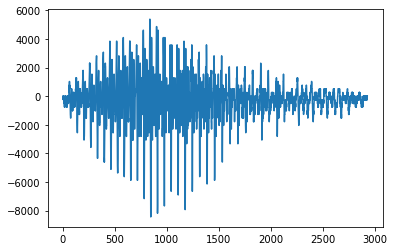

In [6]:
plt.plot(next(original_iter)['audio'])

## データの前処理

データをモデルに入力できるようにするため、データに前処理を行います。

今回は、音声データをすべて1000単位時間にそろえます。音声データの時間をそろえるには、長すぎるデータは途中で切り落とし、短すぎるデータには、後ろに0を付け足すことで長さを揃えます。

また、ミニバッチによる学習を行うため、8個でミニバッチを構築します。

In [7]:
NUM_DATA_POINTS = 1000
BATCH_SIZE = 8

`tf.data.Dataset`には、データセットの内容を編集する機能があります。データセットの中に含まれる1つ1つのデータに対して処理を行うには`.map()`関数を使います。

ここでは、すべての音声データの長さを揃え、入力データと教師ラベルのペアにします。

データセットを読み込むときに、学習用と検証用として分割して準備しました。そのため、データの長さを揃える処理についても、学習用と検証用のそれぞれに実行します。

この処理によって、1サンプルに`audio`、`audio/filename`、`label`の3つのデータが含まれていたデータセットを、同じ長さの音声データと教師ラベルのペアに変換します。

In [8]:
def cut_if_longer(el):
  return (
          tf.reshape(
              tf.cond(
                tf.greater(tf.shape(el['audio']), NUM_DATA_POINTS),
                true_fn=lambda: tf.slice(el['audio'], begin=[0], size=[NUM_DATA_POINTS]),
                false_fn=lambda: tf.slice(tf.concat([el['audio'], tf.zeros(NUM_DATA_POINTS, tf.int64)], axis=0), begin=[0], size=[NUM_DATA_POINTS])
              ),
              shape=(-1, 1)
          ),
          [el['label']]
        )


dataset_prep_train = dataset_train.map(cut_if_longer).batch(BATCH_SIZE)
dataset_prep_valid = dataset_valid.map(cut_if_longer).batch(BATCH_SIZE)

sample = next(iter(dataset_prep_valid))
sample

(<tf.Tensor: shape=(8, 1000, 1), dtype=int64, numpy=
 array([[[    0],
         [ -256],
         [ -256],
         ...,
         [-1792],
         [-1024],
         [    0]],
 
        [[   -8],
         [   -9],
         [  -14],
         ...,
         [  139],
         [  193],
         [  192]],
 
        [[    4],
         [    5],
         [   10],
         ...,
         [  149],
         [  145],
         [  117]],
 
        ...,
 
        [[   -6],
         [   -5],
         [   -3],
         ...,
         [    1],
         [  249],
         [  559]],
 
        [[ -390],
         [ -639],
         [ -797],
         ...,
         [ 1138],
         [-1044],
         [-2135]],
 
        [[ -256],
         [ -256],
         [ -512],
         ...,
         [ -512],
         [ -512],
         [ -768]]])>, <tf.Tensor: shape=(8, 1), dtype=int64, numpy=
 array([[6],
        [7],
        [7],
        [5],
        [1],
        [9],
        [4],
        [4]])>)

変換処理を行った後のデータセットで、1サンプルの音声データを確認します。

変換処理を行った後は、1000単位時間に長さが切られています。

なお、データを取り出すときに、`sample[0][0]`として取り出しています。これは、`sample`はミニバッチ1つを指します。1つ目の`[0]`は8サンプルの入ったミニバッチから0番目を取り出すことを意味します。

変換後の1つのサンプルは、タプルで、0番目には音声データが、1番目に教師ラベルがそれぞれ含まれた形式です。そのため、2つ目の`[0]`で1サンプル中のタプル内、0番目の音声データを読み出していることになります。

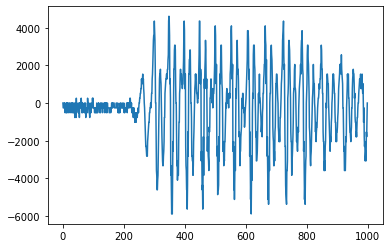

In [9]:
plt.plot(sample[0][0])

## いろいろな再帰型ニューラルネットワーク

データが準備できたので、様々なモデルがデータに対して適用できることを確認しましょう。ここでは、TensorflowのKeras APIを使って、簡単なモデルを構築していきます。

### 小規模な畳み込みネットワーク

最初のモデルでは、1次元の畳み込み演算を用います。このモデルでは1層の畳み込み層とMaxPooling層を持ちます。

このモデルの畳み込み層は、4要素に対して、32個のフィルターで特徴量を抽出します。

また、畳み込み層から出力層に至る接続には、GlobalAveragePooling層で行っています。この層は、Flatten層と同様に、複数のフィルターで捉えられたデータを1列に抽出し、全結合層への接続を可能にします。

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

tf.keras.backend.clear_session()

model_1 = tf.keras.models.Sequential()


model_1.add(layers.Input((NUM_DATA_POINTS, 1)))

model_1.add(layers.Conv1D(32, 4, strides=2, activation='relu'))
model_1.add(layers.MaxPooling1D(2))

model_1.add(layers.GlobalAveragePooling1D())

model_1.add(layers.Dense(10, activation='softmax'))

model_1.summary()


model_1.predict(sample[0])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 499, 32)           160       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 32)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 490
Trainable params: 490
Non-trainable params: 0
_________________________________________________________________


array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.6795603e-36, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.4597011e-13, 4.5790035e-05, 9.9995005e-01, 1.5590024e-29,
        0.0000000e+00, 0.0000000e+00, 4.2041083e-06, 1.2288215e-20,
        2.8004199e-38, 4.5006315e-17],
       [3.7429462e-24, 1.4031417e-09, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.3464415e-17, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.7813898e-11, 2.3245056e-12, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.9544424e-16, 1.5486779e-21,
        0.0000000e+00, 1.1014176e-18],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.1259983e-10, 8.9335614e-08, 9.9999988e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.1095543e-12, 2.11

このモデルを学習できるように準備します。`.compile()`関数で、ロス関数の定義、オプティマイザーの設定を行います。

その後、`.fit()`関数で準備した学習用データと検証用データを渡し学習を行います。

In [11]:
model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_1.fit(
    dataset_prep_train,
    validation_data=dataset_prep_valid,
)

219/219 [==============================] - 3s 5ms/step - loss: 73.7428 - accuracy: 0.1251 - val_loss: 33.0484 - val_accuracy: 0.1600


`.evaluate()`関数を用いることで、学習したモデルの状態を評価することができます。

In [12]:
print('loss / accuracy')
model_1.evaluate(dataset_prep_valid)

loss / accuracy
47/47 [==============================] - 0s 2ms/step - loss: 33.0484 - accuracy: 0.1600


[33.04840850830078, 0.1599999964237213]

### 単純RNNを使用したモデル

次のモデルでは、単純なRNNを特徴量の抽出器として用います。実験に用いるのは、RNNレイヤーの次に直接全結合層を配置したシンプルなモデルです。

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers



tf.keras.backend.clear_session()

model_2 = tf.keras.models.Sequential()

model_2.add(layers.Input((NUM_DATA_POINTS, 1)))
model_2.add(layers.SimpleRNN(128))

model_2.add(layers.Dense(10, activation='softmax'))

model_2.summary()


model_2.predict(sample[0]).shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               16640     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 17,930
Trainable params: 17,930
Non-trainable params: 0
_________________________________________________________________


(8, 10)

単純RNNを用いたモデルは、計算時間が長くかかります。

定義したモデルの学習方法は、畳み込みニューラルネットワークの時と同様です。

In [14]:
model_2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_2.fit(
    dataset_prep_train,
    validation_data=dataset_prep_valid,
)

219/219 [==============================] - 131s 596ms/step - loss: 2.4004 - accuracy: 0.1034 - val_loss: 2.3508 - val_accuracy: 0.1200


### GRUを使用したモデル

RNNやLSTMで問題となっていた計算量を減らすために工夫されたGRUを使ってモデルを定義します。単純RNNのときと同様に、直接全結合層を接続します。

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers



tf.keras.backend.clear_session()

model_3 = tf.keras.models.Sequential()

model_3.add(layers.Input((NUM_DATA_POINTS, 1)))
model_3.add(layers.GRU(128))

model_3.add(layers.Dense(10, activation='softmax'))

model_3.summary()


model_3.predict(sample[0]).shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 51,594
Trainable params: 51,594
Non-trainable params: 0
_________________________________________________________________


(8, 10)

モデルの学習にかかる時間は計算量が少ないため、単純RNNに比べるとずっと短くなります。

In [16]:
model_3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_3.fit(
    dataset_prep_train,
    validation_data=dataset_prep_valid,
)

219/219 [==============================] - 10s 38ms/step - loss: 2.3616 - accuracy: 0.1074 - val_loss: 2.3092 - val_accuracy: 0.1307


### 双方向RNN(LSTM)を使用したモデル

最後に、双方向LSTMを用いたモデルを紹介します。Kerasで双方向に接続されたネットワークを定義するためには、系列データに対するレイヤーを`Bidirectional`レイヤーで準備することで、定義することができます。

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers



tf.keras.backend.clear_session()

model_4 = tf.keras.models.Sequential()

model_4.add(layers.Input((NUM_DATA_POINTS, 1)))
model_4.add(layers.Bidirectional(layers.LSTM(64)))

model_4.add(layers.Dense(10, activation='softmax'))

model_4.summary()


model_4.predict(sample[0]).shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               33792     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 35,082
Trainable params: 35,082
Non-trainable params: 0
_________________________________________________________________


(8, 10)

学習方法は、これまでのモデルと同様に、`.compile()`を行い、`.fit()`に学習データを渡し実行します。

In [20]:
model_4.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_4.fit(
    dataset_prep_train,
    validation_data=dataset_prep_valid,
)

219/219 [==============================] - 15s 56ms/step - loss: 2.2837 - accuracy: 0.1406 - val_loss: 2.1704 - val_accuracy: 0.1867


この資料では、いろいろな要素を使った各モデルが学習できるところまでを確認しています。認識の精度や学習の調整は行われていません。実際のモデル構築では、学習の仕方やモデルの接続をより工夫することで、認識精度を向上させます。

## 勾配のクリッピング

Kerasを用いたモデルで、勾配クリッピングを行う。

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers



tf.keras.backend.clear_session()

model_5 = tf.keras.models.Sequential()

model_5.add(layers.Input((NUM_DATA_POINTS, 1)))
model_5.add(layers.LSTM(64))

model_5.add(layers.Dense(10, activation='softmax'))

model_5.summary()


model_5.predict(sample[0]).shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
_________________________________________________________________


(8, 10)

実装時、勾配クリッピングを行うには、Optimizerの引数に、クリッピングの指定を行う。

In [22]:
model_5.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),
    metrics=['accuracy']
)

model_5.fit(
    dataset_prep_train,
    validation_data=dataset_prep_valid,
)

219/219 [==============================] - 8s 31ms/step - loss: 2.3440 - accuracy: 0.1086 - val_loss: 2.2956 - val_accuracy: 0.1200
